# 1. Checking the Data

In [1]:
# Import spark and start session

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('classification').getOrCreate()

In [2]:
from itertools import chain
from pyspark.sql.functions import count, mean, when, lit, create_map, regexp_extract, desc, col

In [46]:
# Create Spark data frame

df = spark.read.csv('winequality-red.csv', header=True, inferSchema=True, sep=';')

In [4]:
# Print Schema

df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



All the variable looks right so no Schema change needed

In [5]:
# Dataframe visualization

df.show(4)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [6]:
# Visualization in pandas

df.limit(5).toPandas()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
# Data frame visualization by parts

df.select('quality', 'alcohol', 'fixed acidity', 'pH').show(4)

+-------+-------+-------------+----+
|quality|alcohol|fixed acidity|  pH|
+-------+-------+-------------+----+
|      5|    9.4|          7.4|3.51|
|      5|    9.8|          7.8| 3.2|
|      5|    9.8|          7.8|3.26|
|      6|    9.8|         11.2|3.16|
+-------+-------+-------------+----+
only showing top 4 rows



In [8]:
df.select('quality', 'alcohol', 'fixed acidity', 'pH').summary().show()

+-------+------------------+------------------+------------------+-------------------+
|summary|           quality|           alcohol|     fixed acidity|                 pH|
+-------+------------------+------------------+------------------+-------------------+
|  count|              1599|              1599|              1599|               1599|
|   mean|5.6360225140712945|10.422983114446502| 8.319637273295838|  3.311113195747343|
| stddev|0.8075694397347051|1.0656675818473935|1.7410963181276948|0.15438646490354271|
|    min|                 3|               8.4|               4.6|               2.74|
|    25%|                 5|               9.5|               7.1|               3.21|
|    50%|                 6|              10.2|               7.9|               3.31|
|    75%|                 6|              11.1|               9.2|                3.4|
|    max|                 8|              14.9|              15.9|               4.01|
+-------+------------------+---------------

In [9]:
print('Number of rows: \t', df.count())
print('Number of columns: \t', len(df.columns))

Number of rows: 	 1599
Number of columns: 	 12


# 2. Exploratory Data Analysis

In [10]:
# Target Variable counts

df.groupBy('quality').count().show()

+-------+-----+
|quality|count|
+-------+-----+
|      6|  638|
|      3|   10|
|      5|  681|
|      4|   53|
|      8|   18|
|      7|  199|
+-------+-----+



In [11]:
# Checking some variable means group by target variable

df.groupBy('quality').mean('fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar').show()

+-------+------------------+---------------------+-------------------+-------------------+
|quality|avg(fixed acidity)|avg(volatile acidity)|   avg(citric acid)|avg(residual sugar)|
+-------+------------------+---------------------+-------------------+-------------------+
|      6| 8.347178683385575|  0.49748432601880965| 0.2738244514106587|  2.477194357366772|
|      3|              8.36|   0.8845000000000001|0.17099999999999999| 2.6350000000000002|
|      5| 8.167254038179149|   0.5770411160058732|0.24368575624082198|  2.528854625550658|
|      4| 7.779245283018868|   0.6939622641509429| 0.1741509433962264|   2.69433962264151|
|      8| 8.566666666666665|   0.4233333333333334|0.39111111111111113| 2.5777777777777775|
|      7| 8.872361809045225|   0.4039195979899498|0.37517587939698493| 2.7206030150753793|
+-------+------------------+---------------------+-------------------+-------------------+



In [12]:
df.groupBy('quality').mean('chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density').show()

+-------+-------------------+------------------------+-------------------------+------------------+
|quality|     avg(chlorides)|avg(free sulfur dioxide)|avg(total sulfur dioxide)|      avg(density)|
+-------+-------------------+------------------------+-------------------------+------------------+
|      6|0.08495611285266458|      15.711598746081505|        40.86990595611285|0.9966150626959255|
|      3|0.12250000000000001|                    11.0|                     24.9|0.9974640000000001|
|      5|0.09273568281938328|      16.983847283406753|        56.51395007342144|0.9971036270190888|
|      4|0.09067924528301884|      12.264150943396226|        36.24528301886792|0.9965424528301886|
|      8|0.06844444444444445|      13.277777777777779|        33.44444444444444|0.9952122222222223|
|      7|0.07658793969849244|      14.045226130653266|        35.02010050251256|0.9961042713567828|
+-------+-------------------+------------------------+-------------------------+------------------+


In [13]:
df.groupBy('quality').mean('pH', 'sulphates', 'alcohol').show()

+-------+------------------+------------------+------------------+
|quality|           avg(pH)|    avg(sulphates)|      avg(alcohol)|
+-------+------------------+------------------+------------------+
|      6|3.3180721003134837|0.6753291536050158|10.629519331243463|
|      3|3.3979999999999997|0.5700000000000001| 9.955000000000002|
|      5|3.3049486049926546|0.6209691629955947| 9.899706314243753|
|      4| 3.381509433962264|0.5964150943396227|10.265094339622639|
|      8|3.2672222222222214|0.7677777777777778|12.094444444444443|
|      7| 3.290753768844219|0.7412562814070353|11.465912897822443|
+-------+------------------+------------------+------------------+



# 3. Distributions

In [14]:
# Create pandas dataframe to visualize data

pandas_df = df.toPandas()

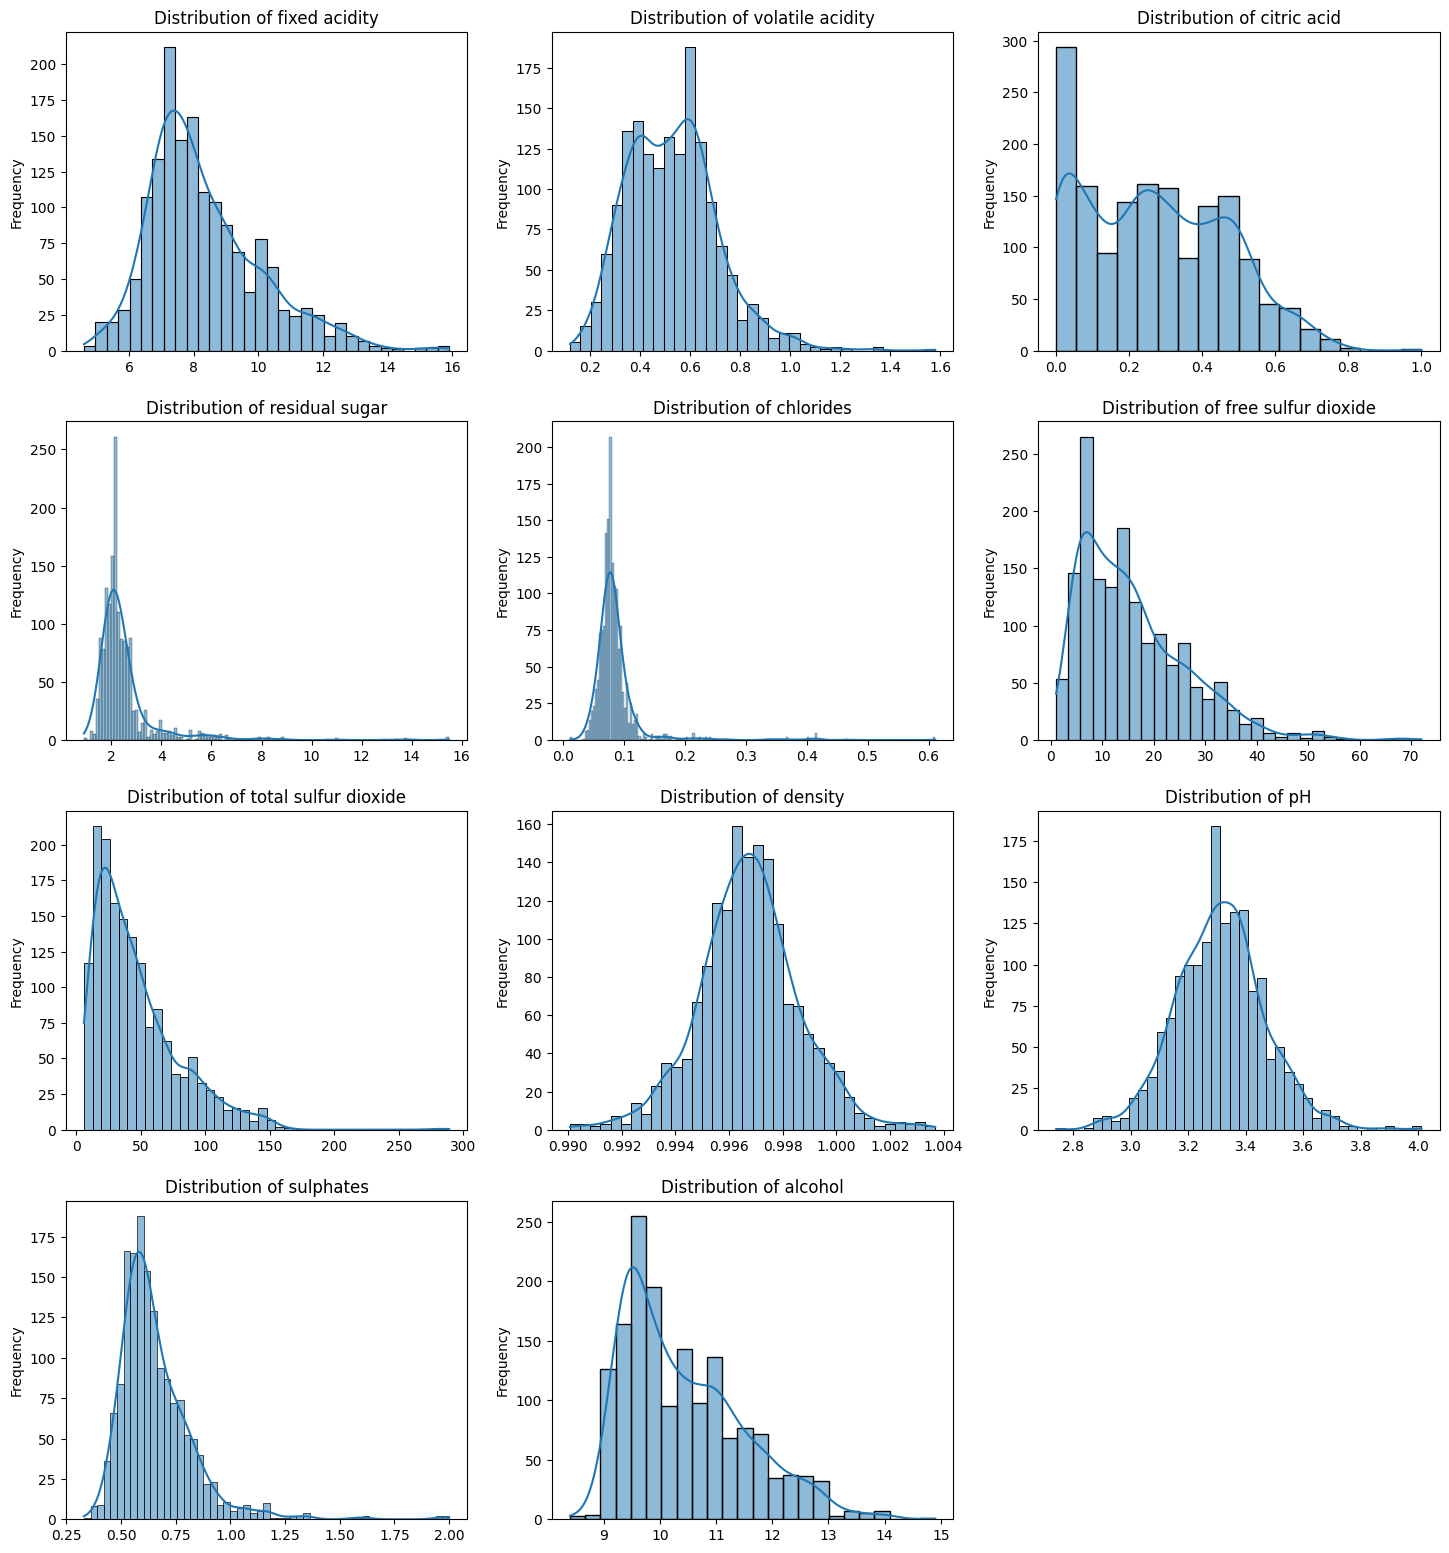

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.tight_layout(pad=3.0)

columns = pandas_df.columns.drop('quality')
for i, column in enumerate(columns):
    row, col = divmod(i, 3)
    sns.histplot(pandas_df[column], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"Distribution of {column}")
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("Frequency")

for j in range(len(columns), 12):
    fig.delaxes(axes[3, j - 9])

plt.show()

Exploring the data revealed a mix of distributions, with certain features showing significant skew. For instance, variables like total sulfur dioxide and residual sugar presented long right tails, while others, such as pH and density, showed a more balanced distribution.

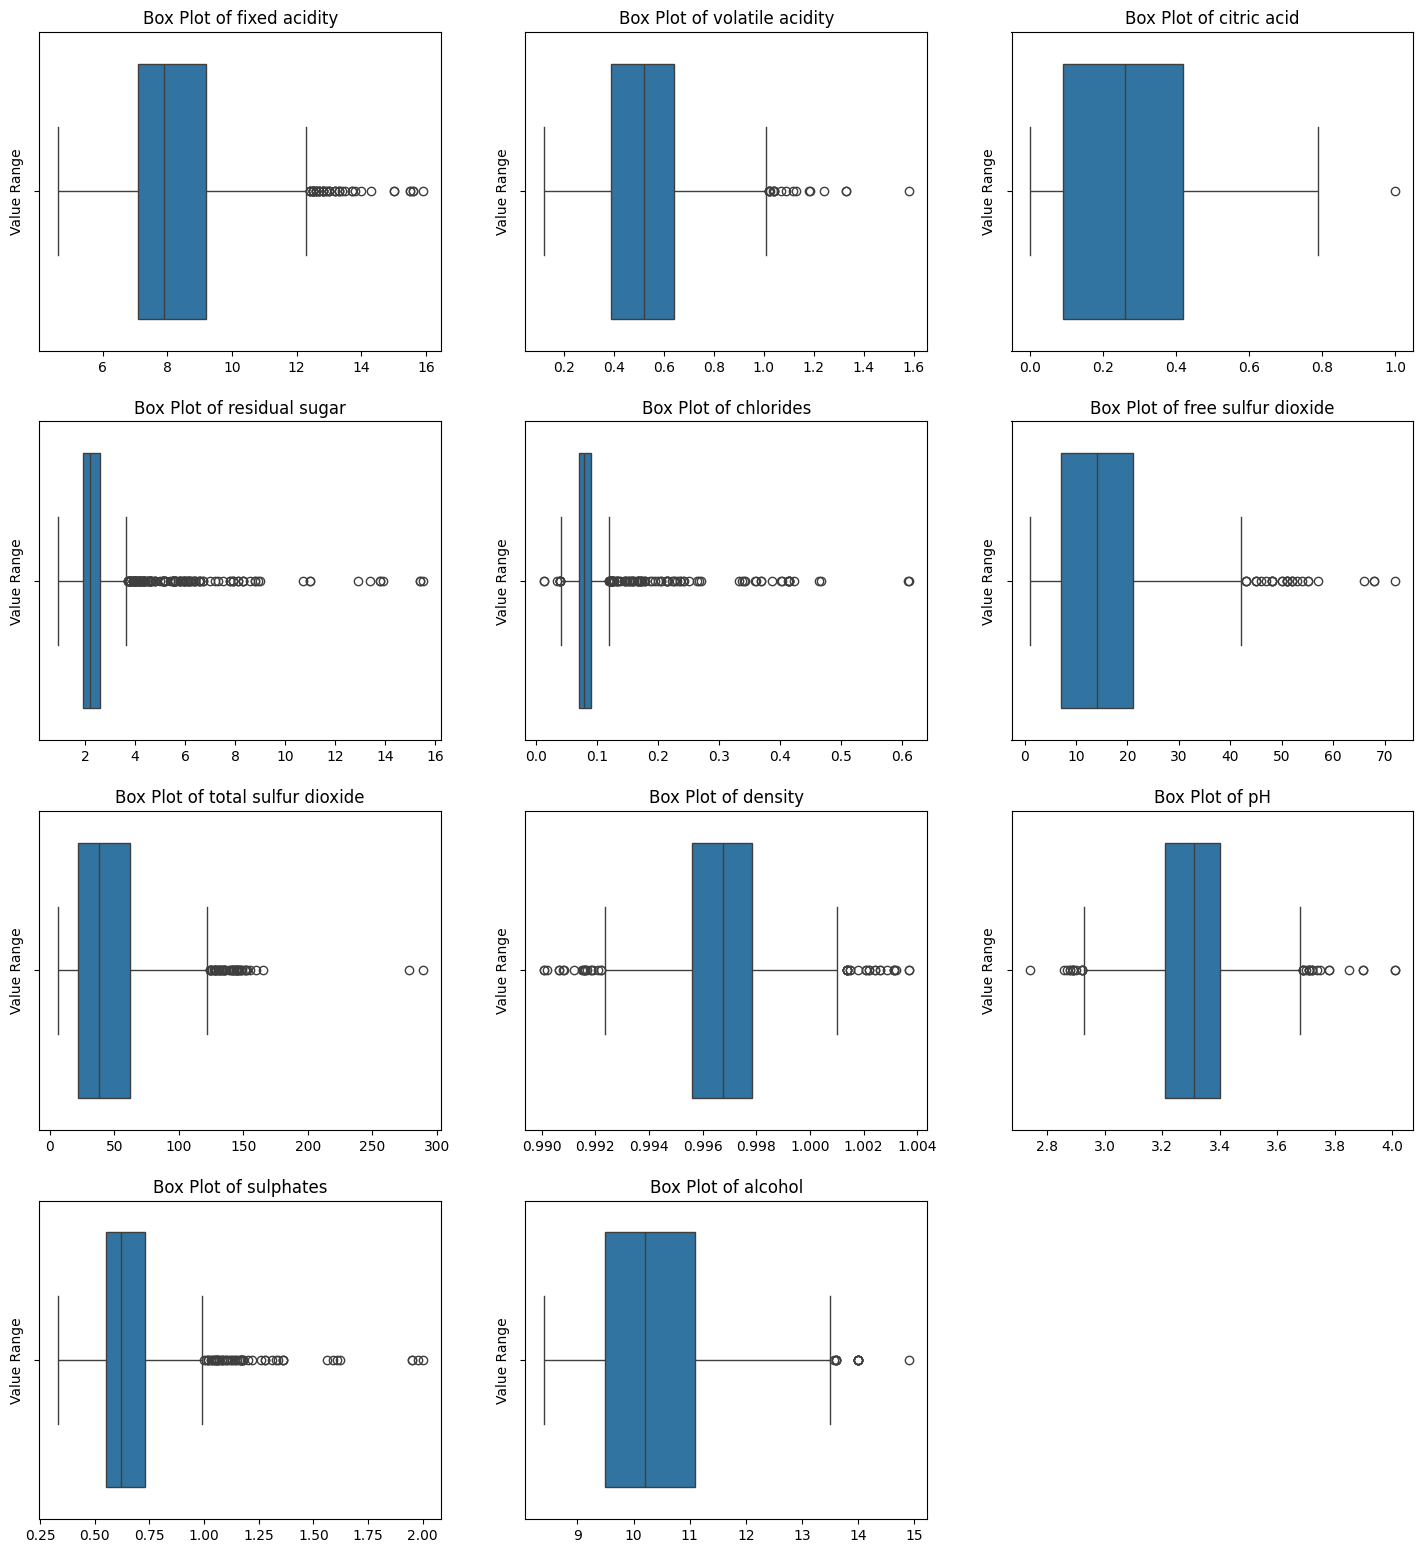

In [16]:
# We visualize the outliers

fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.tight_layout(pad=3.0)

for i, column in enumerate(pandas_df.columns[:-1]):
    row, col = divmod(i, 3)
    sns.boxplot(data=pandas_df, x=column, ax=axes[row, col])
    axes[row, col].set_title(f"Box Plot of {column}")
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("Value Range")

for j in range(len(pandas_df.columns) - 1, 12):
    fig.delaxes(axes[j // 3, j % 3])

plt.show()

Several of these distributions technically have outliers but they represent real values for the most part.

However, it seems total sulfur dioxide has true potential outliers. Questions:  

1. What are the exact values and counts for these and how does this compare to the free sulfur dioxide? i.e., if total sulfur dioxide is high, I would assume free is also be high.

1. What's the distribution of free sulfur dioxide percent and is it associated with wine quality?

Several distributions have a right skew. It makes sense to treat for outliers first before normalizing for skewness so the extreme values don't distort subsequent transformations.

In [46]:
# Calculate value counts and sort in descending order

total_sulfur_dioxide_count = df.groupBy("total sulfur dioxide") \
    .agg(count("*").alias("count")) \
    .orderBy(desc("count"))

# Sort by index (total sulfur dioxide values) in descending order

sorted_counts = df.groupBy("total sulfur dioxide") \
    .agg(count("*").alias("count")) \
    .orderBy(desc("total sulfur dioxide"))

# To see the results:

total_sulfur_dioxide_count.show()
sorted_counts.show()

+--------------------+-----+
|total sulfur dioxide|count|
+--------------------+-----+
|                28.0|   43|
|                24.0|   36|
|                18.0|   35|
|                15.0|   35|
|                23.0|   34|
|                14.0|   33|
|                20.0|   33|
|                31.0|   32|
|                38.0|   31|
|                27.0|   30|
|                19.0|   29|
|                12.0|   29|
|                13.0|   28|
|                25.0|   27|
|                17.0|   27|
|                10.0|   27|
|                42.0|   26|
|                11.0|   26|
|                37.0|   26|
|                35.0|   26|
+--------------------+-----+
only showing top 20 rows

+--------------------+-----+
|total sulfur dioxide|count|
+--------------------+-----+
|               289.0|    1|
|               278.0|    1|
|               165.0|    1|
|               160.0|    1|
|               155.0|    1|
|               153.0|    1|
|               1

In [45]:
from pyspark.sql.functions import count, mean, when, lit, create_map, regexp_extract, desc, col

df.filter(col("total sulfur dioxide") > 150).show()


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          8.1|           0.785|       0.52|           2.0|    0.122|               37.0|               153.0| 0.9969|3.21|     0.69|    9.3|      5|
|          6.1|            0.21|        0.4|           1.4|    0.066|               40.5|               165.0| 0.9912|3.25|     0.59|   11.9|      6|
|          8.5|           0.655|       0.49|           6.1|    0.122|               34.0|               151.0|  1.001|3.31|     1.14|    9.3|      5|
|          9.8|            0.88|       0.25|           2.5|    0.104|               35.0|           

In [9]:
# Calculate the total number of rows

total_count = df.count()

# Calculate the number of rows with total sulfur dioxide > 150

high_sulfur_count = df.filter(col("total sulfur dioxide") > 150).count()

# Calculate the percentage

percentage_high_sulfur = (high_sulfur_count / total_count) * 100

print(f"Percentage of data with total sulfur dioxide > 150: {percentage_high_sulfur:.2f}%")

Percentage of data with total sulfur dioxide > 150: 0.56%


Stidies shows that red wine mostly have a total sulfur dioxided level of 150 ppm or less.

Therefore, rows that have a total sulfur dioxide level greater than 150 ppm are likely data entry errors and also amount to less than 5% of data (a small enough portion to not significantly affect the overall dataset).

Source: https://grape-to-glass.com/index.php/sulphur-levels-wine/

In [47]:
# Filter the DataFrame

df = df.filter(col("total sulfur dioxide") <= 150)

# Reset the index (not necessary in PySpark)
# In PySpark, DataFrames don't have an explicit index like Pandas,
# so resetting the index is not needed.

# Get the updated DataFrame size
updated_count = df.count()

print(f"Updated DataFrame count: {updated_count}")

Updated DataFrame count: 1590


# 4. Normalizing the data

Box-Cox will be used to normalize the data as it provides a more tailored transformation to suit the data's unique skewness.

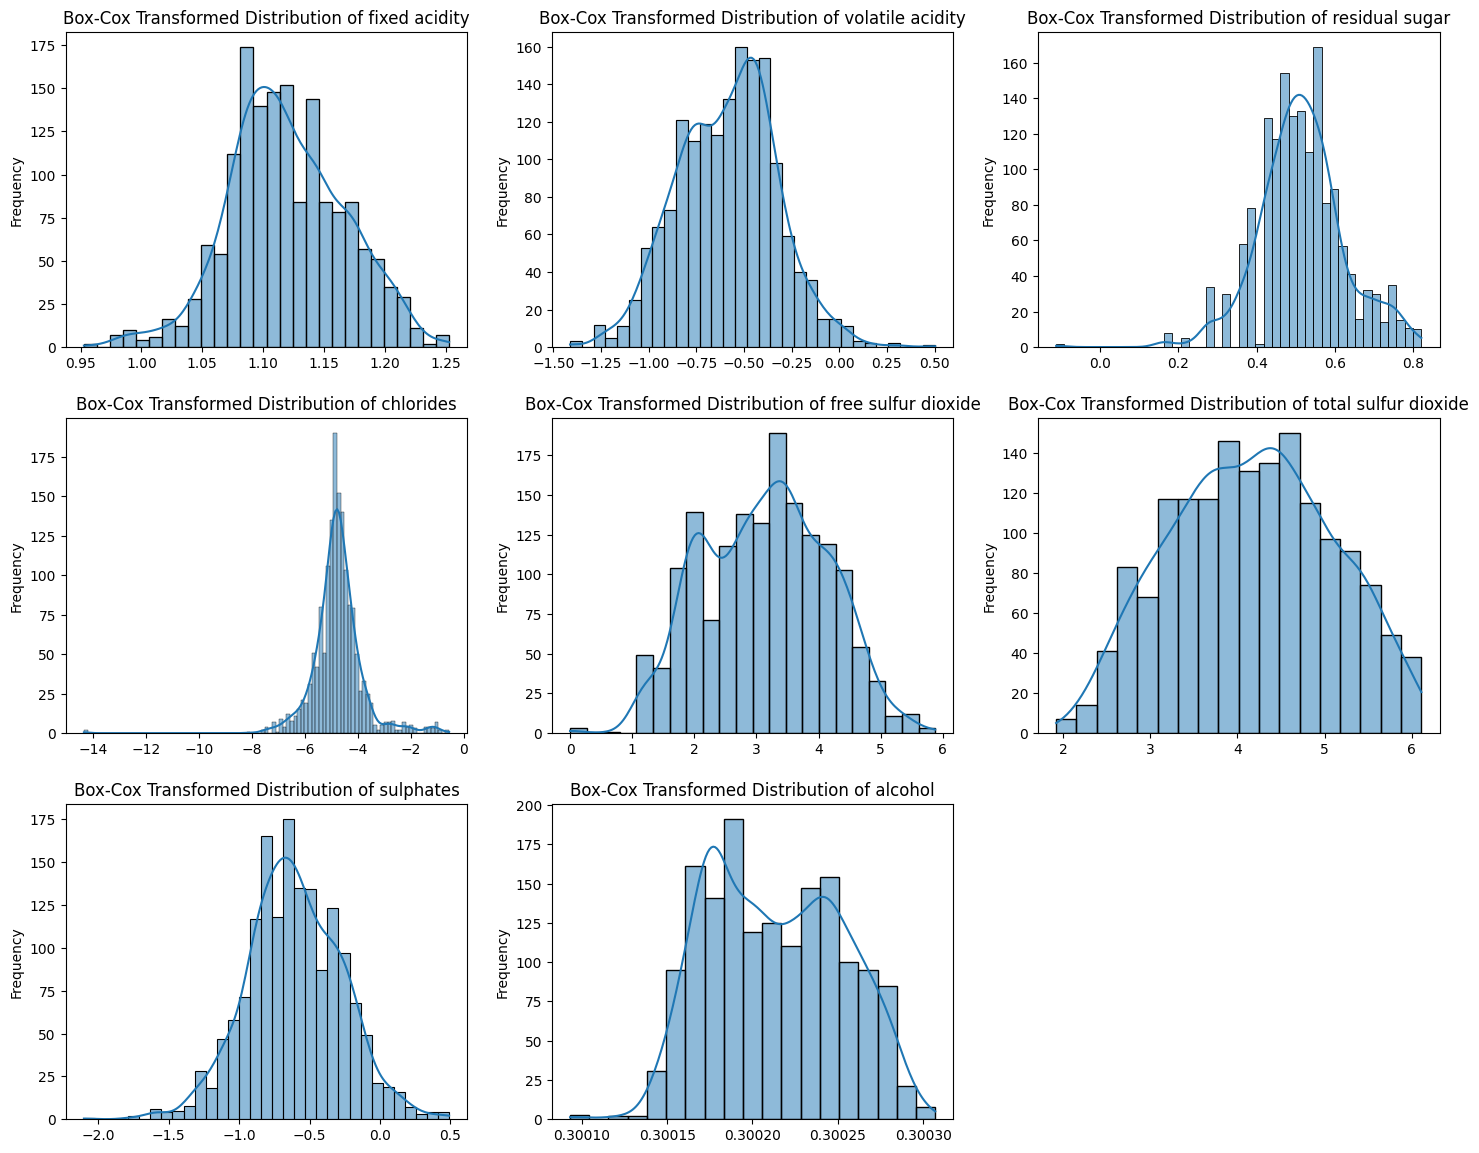

In [48]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from scipy.stats import boxcox
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting variables that will be normalized
skewed_columns = ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides',
                  'free sulfur dioxide', 'total sulfur dioxide', 'sulphates', 'alcohol']

# Collect the selected columns from the Spark DataFrame into a pandas DataFrame
pandas_df = df.toPandas()

transformed_columns = {}
for column in skewed_columns:
    transformed_columns[f'{column}_boxcox'], _ = boxcox(pandas_df[column])

transformed_df = pd.DataFrame(transformed_columns)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.tight_layout(pad=3.0)

for i, column in enumerate(skewed_columns):
    row, col = divmod(i, 3)
    sns.histplot(transformed_df[f'{column}_boxcox'], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"Box-Cox Transformed Distribution of {column}")
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("Frequency")

for j in range(len(skewed_columns), 9):
    fig.delaxes(axes[j // 3, j % 3])

plt.show()

In [49]:
for column in skewed_columns:
    pandas_df[column], _ = boxcox(pandas_df[column])

pandas_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.098022,-0.331666,0.00,0.451419,-4.922816,2.883222,4.054288,0.9978,3.51,-0.799278,0.300172,5
1,1.111423,-0.124520,0.00,0.575361,-4.141925,4.132563,4.969183,0.9968,3.20,-0.475814,0.300194,5
2,1.111423,-0.259466,0.04,0.532241,-4.327579,3.337304,4.673025,0.9970,3.26,-0.545194,0.300194,5
3,1.191699,-0.990201,0.56,0.451419,-4.966044,3.526587,4.817063,0.9980,3.16,-0.735813,0.300194,6
4,1.098022,-0.331666,0.00,0.451419,-4.922816,2.883222,4.054288,0.9978,3.51,-0.799278,0.300172,5



# 5. Correlation Analysis

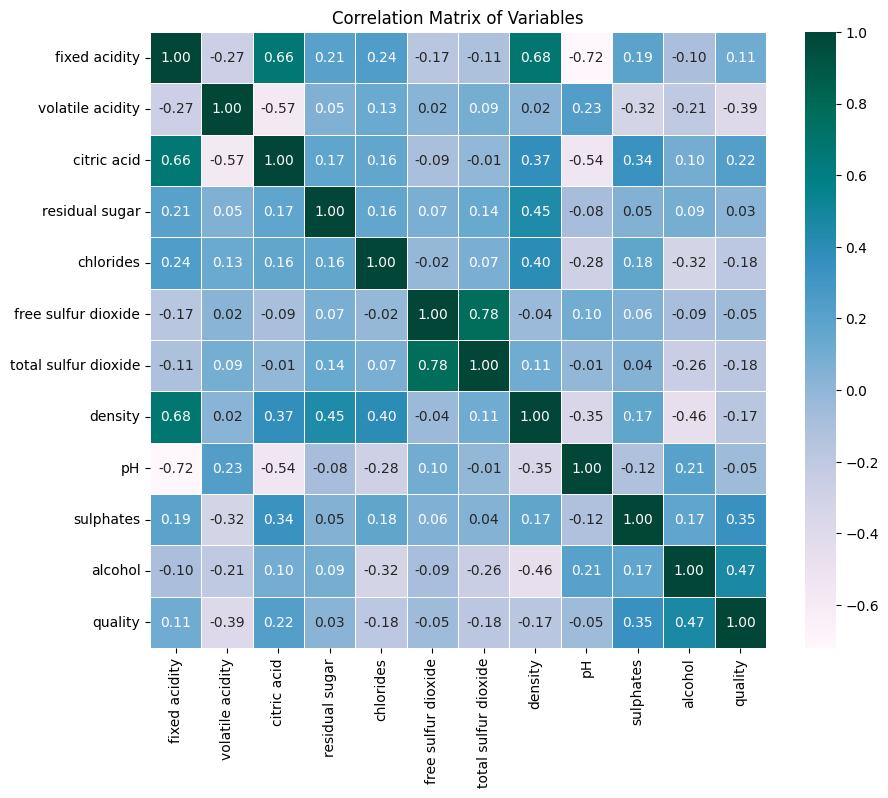

In [13]:
correlation_matrix = pandas_df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap="PuBuGn", fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Matrix of Variables")
plt.show()

# Our target variable is a ordinal categorical variable and so we can include it here.

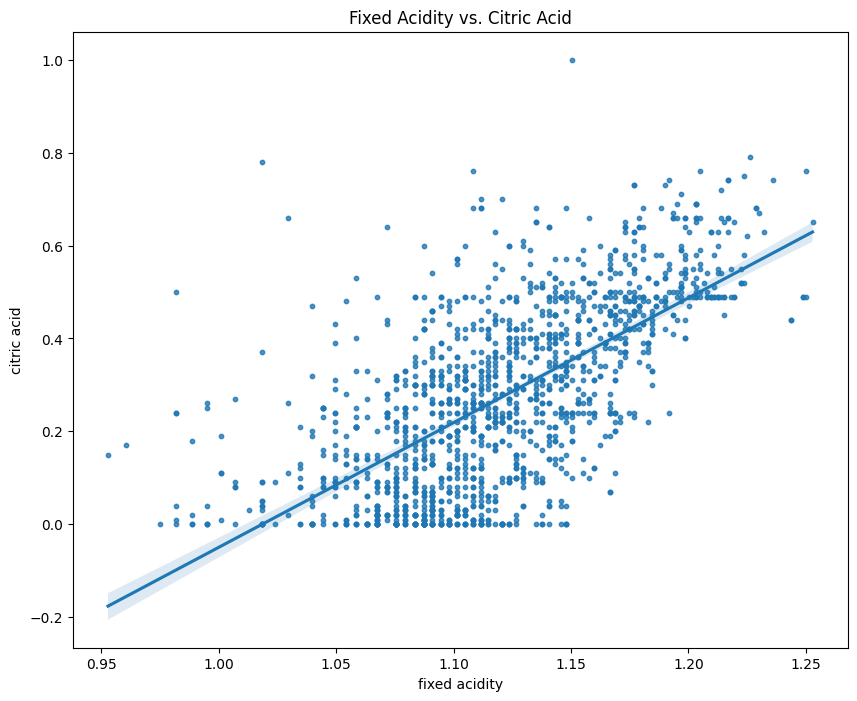

In [18]:
plt.figure(figsize=(10, 8))
sns.regplot(x='fixed acidity', y='citric acid', data=pandas_df, scatter_kws={'s':10})
plt.title('Fixed Acidity vs. Citric Acid')
plt.show()

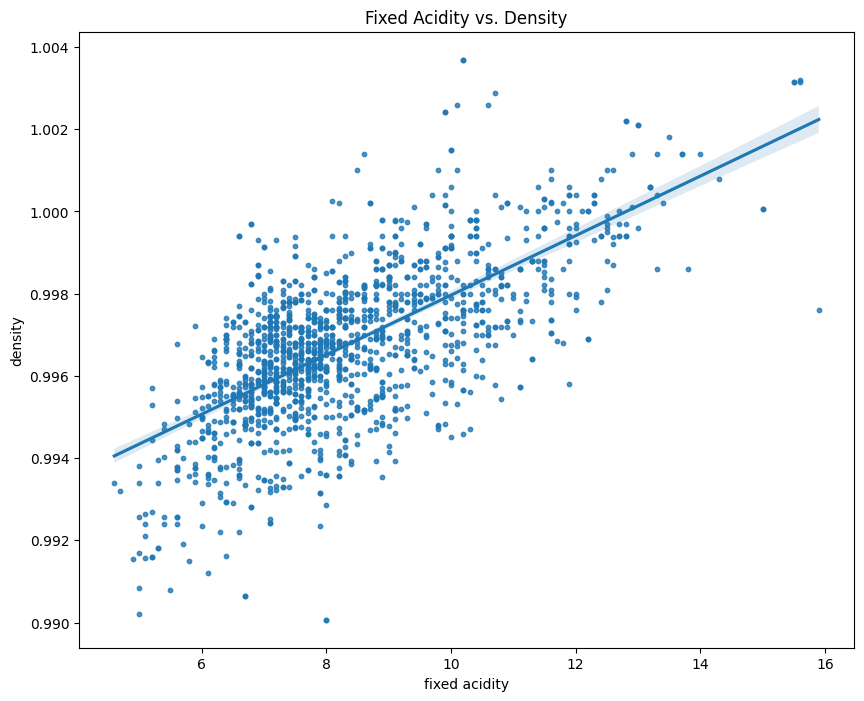

In [25]:
plt.figure(figsize=(10, 8))
sns.regplot(x='fixed acidity', y='density', data=pandas_df, scatter_kws={'s':10})
plt.title('Fixed Acidity vs. Density')
plt.show()

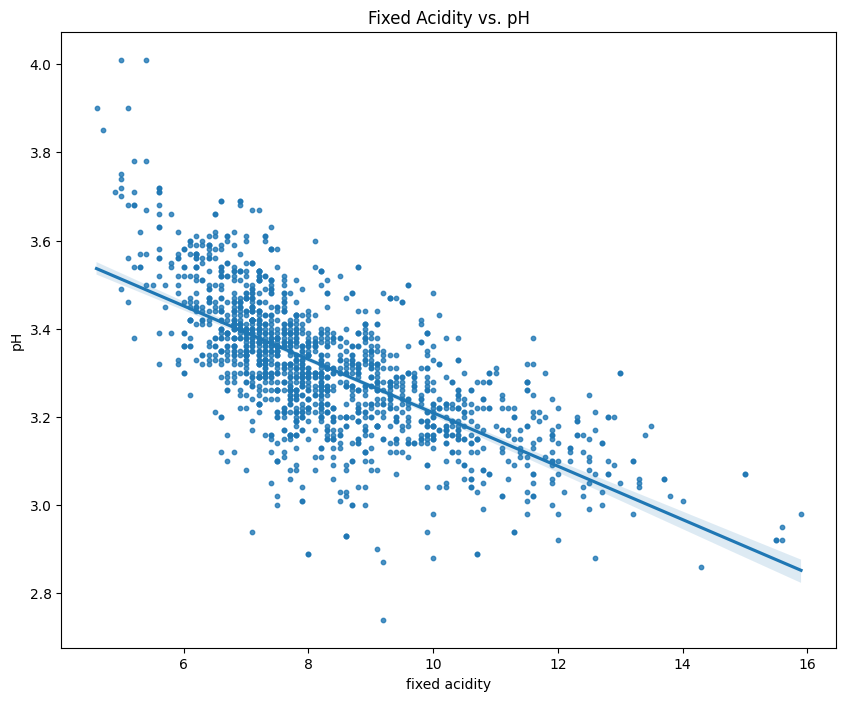

In [26]:
plt.figure(figsize=(10, 8))
sns.regplot(x='fixed acidity', y='pH', data=pandas_df, scatter_kws={'s':10})
plt.title('Fixed Acidity vs. pH')
plt.show()

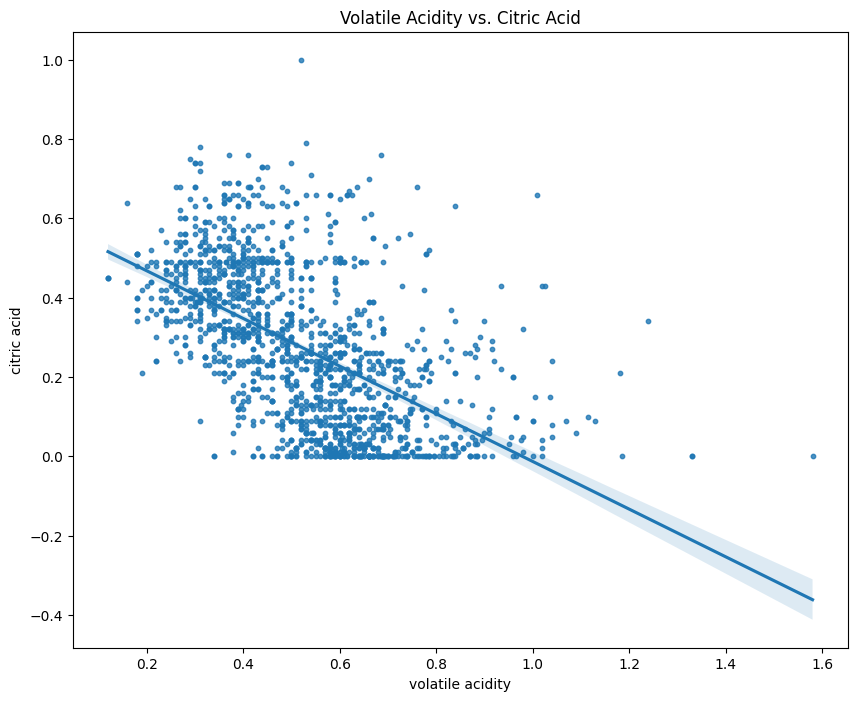

In [27]:
plt.figure(figsize=(10, 8))
sns.regplot(x='volatile acidity', y='citric acid', data=pandas_df, scatter_kws={'s':10})
plt.title('Volatile Acidity vs. Citric Acid')
plt.show()

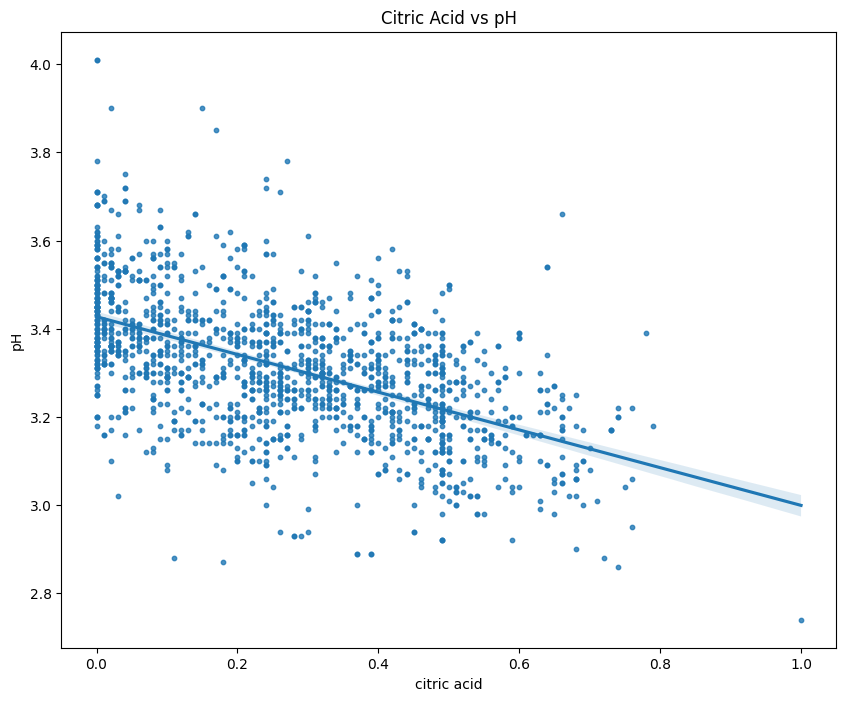

In [14]:
plt.figure(figsize=(10, 8))
sns.regplot(x='citric acid', y='pH', data=pandas_df, scatter_kws={'s':10})
plt.title('Citric Acid vs pH')
plt.show()

In [50]:
df = spark.createDataFrame(pandas_df)

# 5. Analyzing target variable & it's distribution

In [51]:
# Target Variable counts

df.groupBy('quality').count().orderBy('quality').show()

+-------+-----+
|quality|count|
+-------+-----+
|      3|   10|
|      4|   53|
|      5|  676|
|      6|  636|
|      7|  197|
|      8|   18|
+-------+-----+



To facilitate classification, I converted quality ratings to a binary outcome: wines with scores of 7 or higher were labeled as “good” (1), while those below 7 were labeled as “not good” (0). This reclassification yielded an 86\% to 14\% split, slightly accentuating the imbalance and presenting a unique challenge in ensuring accurate predictions for the minority “good" class. The transformed distribution of the target variable informed the choice of classification metrics and underscored the importance of performance metrics that account for imbalance, like ROC-AUC and precision-recall, throughout model evaluation.

In [52]:
# Create the binary target column
df = df.withColumn('y_binary', F.when(df['quality'] >= 7, 1).otherwise(0))

# Show the resulting DataFrame to verify
df.select('quality', 'y_binary').show(10)

+-------+--------+
|quality|y_binary|
+-------+--------+
|      5|       0|
|      5|       0|
|      5|       0|
|      6|       0|
|      5|       0|
|      5|       0|
|      5|       0|
|      7|       1|
|      7|       1|
|      5|       0|
+-------+--------+
only showing top 10 rows



In [53]:
# Calculate the class distribution (percentage of 0's and 1's)
class_counts = df.groupBy('y_binary').count()

# Calculate the percentage distribution
total_count = df.count()
class_distribution = class_counts.withColumn('percentage', (class_counts['count'] / total_count) * 100)

# Show the class distribution
class_distribution.show()

+--------+-----+------------------+
|y_binary|count|        percentage|
+--------+-----+------------------+
|       1|  215|13.522012578616351|
|       0| 1375| 86.47798742138365|
+--------+-----+------------------+



In [54]:
# Drop the target column ('quality') from the features
X = df.drop('quality')

# Show the resulting DataFrame to verify
X.show(5)

+------------------+--------------------+-----------+------------------+------------------+-------------------+--------------------+-------+----+--------------------+------------------+--------+
|     fixed acidity|    volatile acidity|citric acid|    residual sugar|         chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|           sulphates|           alcohol|y_binary|
+------------------+--------------------+-----------+------------------+------------------+-------------------+--------------------+-------+----+--------------------+------------------+--------+
|1.0980217087126725|-0.33166633976471893|        0.0|0.4514188970516045|  -4.9228157534378|  2.883221805082891|   4.054287510380336| 0.9978|3.51| -0.7992781659173865|0.3001715584673396|       0|
| 1.111422913165382|-0.12451993815072684|        0.0|0.5753611399371347|-4.141924545711294|  4.132563085387281|  4.9691832424647355| 0.9968| 3.2|-0.47581440129271907|0.3001939472537757|       0|
| 1.111422913165382| -0.2

In [55]:
# Split the dataset into two groups based on the 'y_binary' column (target)
# First, you need to ensure that you have the target 'y_binary' column in the DataFrame

# Create a DataFrame with the features and target column
df_with_target = df.withColumn("y_binary", F.when(df['quality'] >= 7, 1).otherwise(0))

# Split the dataset based on 'y_binary' to ensure stratification
df_class_0 = df_with_target.filter(df_with_target['y_binary'] == 0)
df_class_1 = df_with_target.filter(df_with_target['y_binary'] == 1)

# Perform randomSplit on both class 0 and class 1, e.g., 70% for training, 30% for testing
train_class_0, test_class_0 = df_class_0.randomSplit([0.7, 0.3], seed=42)
train_class_1, test_class_1 = df_class_1.randomSplit([0.7, 0.3], seed=42)

# Combine the training and testing sets for both classes
train_df = train_class_0.union(train_class_1)
test_df = test_class_0.union(test_class_1)

# Show the distribution in the training and test sets to verify stratification
train_df.groupBy('y_binary').count().show()
test_df.groupBy('y_binary').count().show()

+--------+-----+
|y_binary|count|
+--------+-----+
|       0|  976|
|       1|  139|
+--------+-----+

+--------+-----+
|y_binary|count|
+--------+-----+
|       0|  399|
|       1|   76|
+--------+-----+



# 6. Model building

In [16]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression,\
                    RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

In [56]:
vec_asmbl = VectorAssembler(inputCols=df.columns[:10],
                           outputCol='features')

df1 = vec_asmbl.transform(df).select('features', 'y_binary')
df1.show(4, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|features                                                                                                                                               |y_binary|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|[1.0980217087126725,-0.33166633976471893,0.0,0.4514188970516045,-4.9228157534378,2.883221805082891,4.054287510380336,0.9978,3.51,-0.7992781659173865]  |0       |
|[1.111422913165382,-0.12451993815072684,0.0,0.5753611399371347,-4.141924545711294,4.132563085387281,4.9691832424647355,0.9968,3.2,-0.47581440129271907]|0       |
|[1.111422913165382,-0.2594663377730236,0.04,0.5322408848095973,-4.327578890504731,3.3373042482406743,4.673025028080861,0.997,3.26,-0.5451937259091881] |0       |
|[1.1916989778240046,-

In [57]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)

In [58]:
scalerModel = scaler.fit(df1)

In [59]:
scaledData = scalerModel.transform(df1)

In [60]:
scaledData.show(4, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                               |y_binary|scaledFeatures                                                                                                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+--------+------------------------------------------------------------------------------------------------------------

In [61]:
scaledData = scaledData.drop('features')

In [62]:
# Rename 'scaledFeatures' to 'features'

scaledData = scaledData.withColumnRenamed("scaledFeatures", "features")

# Display the updated DataFrame (optional)

scaledData.show(5)

+--------+--------------------+
|y_binary|            features|
+--------+--------------------+
|       0|[-0.4408609547651...|
|       0|[-0.1604101352808...|
|       0|[-0.1604101352808...|
|       0|[1.51954991591737...|
|       0|[-0.4408609547651...|
+--------+--------------------+
only showing top 5 rows



In [63]:
train_df, valid_df = scaledData.randomSplit([0.7, 0.3])

In [64]:
train_df.show(4, truncate=False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|y_binary|features                                                                                                                                                                                           |
+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0       |[-3.4803519011784068,0.0584465522634274,-0.616867530882296,-0.1728301367539466,-1.4138141100185388,-0.7073358549131366,0.8293262541686114,-1.783707110672388,3.811885075152605,-0.5653232703101299]|
|0       |[-3.3207879092821746,0.4924250257883243,-0.5140885961549722,0.15535605484066578,-1.1360581313058133,0.3916377009144441,1.578515222457554,-1.89028092189228,3.48793

In [68]:
evaluator = MulticlassClassificationEvaluator(labelCol='y_binary',
                                          metricName='accuracy')

# 7. Evaluation and metric


In [69]:
evaluator = MulticlassClassificationEvaluator(labelCol='y_binary',
                                          metricName='accuracy')

In [70]:
ridge = LogisticRegression(labelCol='y_binary',
                        maxIter=100,
                        elasticNetParam=0, # Ridge regression is choosen
                        regParam=0.03)

model = ridge.fit(train_df)
pred = model.transform(valid_df)
evaluator.evaluate(pred)

0.8765182186234818

In [71]:
lasso = LogisticRegression(labelCol='y_binary',
                           maxIter=100,
                           elasticNetParam=1, # Lasso
                           regParam=0.0003)

model = lasso.fit(train_df)
pred = model.transform(valid_df)
evaluator.evaluate(pred)

0.8724696356275303

# 8. Conclusions

This analysis was particularly challenging due to the imbalanced data and the number of labels available. However, by consolidating the data into two classes, we were able to efficiently predict whether the wine would be of high quality or not